# Explore datasets

There are three datasets:
- ED_visits.csv 
- specialty.csv
- yet_to_arrive.csv

See the data dictionaries for more information. 

The ED visits database uses the following concepts:

- visit: a single visit to the ED which may end in admission or discharge
- prediction times: the times in the day at which predictions are to be made (eg 06:00, 09:30, 12:00, 15:30, 22:00)
- visit snapshots: snapshots of visits observed at the prediction times; a vist may have multiple visit snapshots



## Set up the notebook environment


In [1]:
# Reload functions every time
%load_ext autoreload 
%autoreload 2

In [2]:
from pathlib import Path
import sys
import json


import pandas as pd
import matplotlib.pyplot as plt
import numpy as np


PROJECT_ROOT = Path().home() 
USER_ROOT = Path().home() / 'work'

sys.path.append(str(USER_ROOT / 'patientflow' / 'patientflow'))
sys.path.append(str(USER_ROOT / 'patientflow' / 'functions'))
sys.path.append(str(USER_ROOT / 'ed-predictor' / 'functions'))


data_path = Path(USER_ROOT / 'ed-predictor' / 'data-raw')



## Load parameters

These are set in config.json. You can change these for your own purposes. But the times of day will need to match those in the provided dataset if you want to run this notebook successfully.

In [3]:
# Load the times of day
import yaml

config_path = Path(USER_ROOT / 'patientflow')

with open(config_path / 'config.yaml', 'r') as file:
    config = yaml.safe_load(file)
    
# Convert list of times of day at which predictions will be made (currently stored as lists) to list of tuples
prediction_times = [tuple(item) for item in config['prediction_times']]

# See the times of day at which predictions will be made
prediction_times

[(6, 0), (9, 30), (12, 0), (15, 30), (22, 0)]

## Explore ED visits data

In [4]:
start_date = '20220101'
end_date = '20240301'

In [5]:
import pandas as pd
import pickle

# csv_filename = 'ed_visits.csv'
# data_path = Path(USER_ROOT / 'ed-predictor' / 'data-raw')
# full_path = data_path / csv_filename
# visits = pd.read_csv(full_path)

data_filename = 'ed_visits_' + start_date + '_' + end_date + '.pickle'
data_path = Path(USER_ROOT / 'ed-predictor' / 'data-raw')
full_path = data_path / data_filename

with open(full_path, 'rb') as f:
    visits = pickle.load(f)

In [6]:
# certain columns are not used in training
exclude_from_plot = [
    "snapshot_id", 
    "visit_number",
    "snapshot_date",
    "prediction_time",
    "random_number",
    "training_validation_test", 
    "is_admitted"]

In [7]:
from plot_data import main_plot_function

# dict_cols

NameError: name 'df' is not defined

### Arrival and demographic variables



In [11]:
from data_dict_functions import get_dict_cols
dict_cols = get_dict_cols(visits)

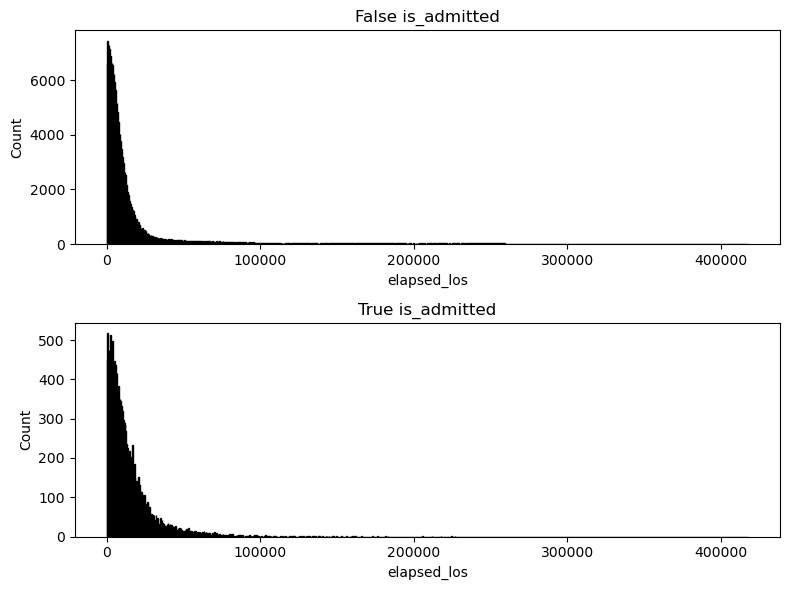

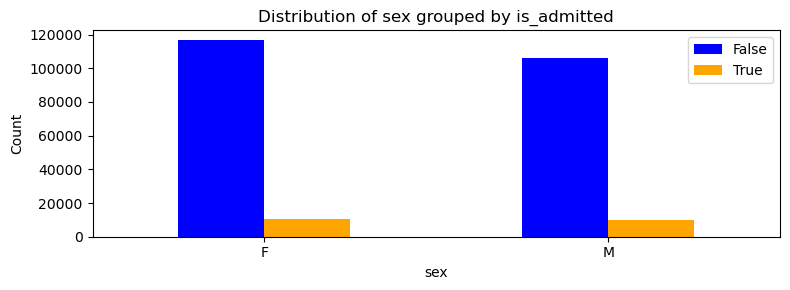

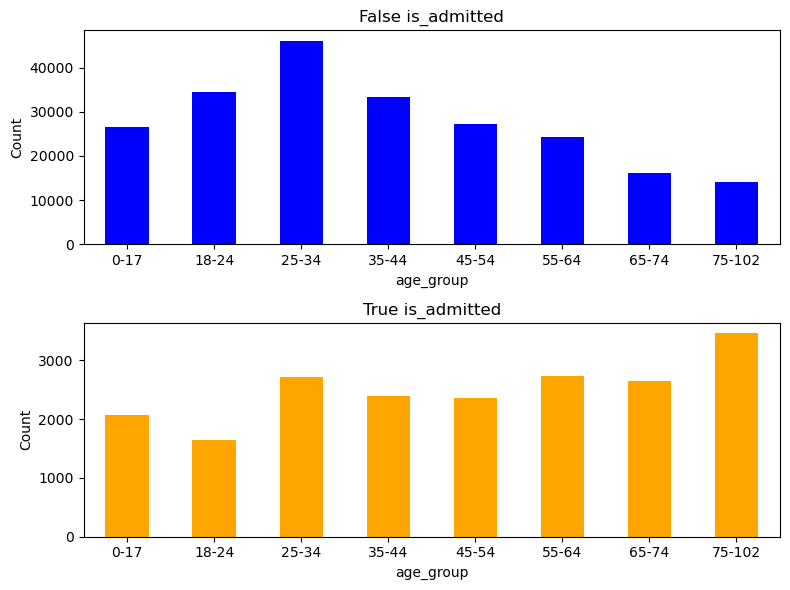

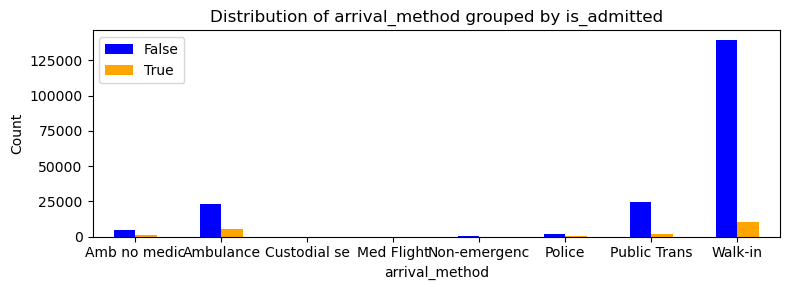

In [12]:
main_plot_function(visits[dict_cols['arrival and demographic'] + ['is_admitted']], exclude_from_plot)

### Summary variables

In [20]:
visits[visits.elapsed_los > 3 * 24*60*60]['elapsed_los']/(60*60)

snapshot_id
241       72.133333
1706      72.733333
4431      72.266667
9139      72.216667
10058     72.133333
            ...    
231962    72.227500
234425    72.086389
237189    72.005833
237300    72.023611
238600    72.019167
Name: elapsed_los, Length: 75, dtype: float64

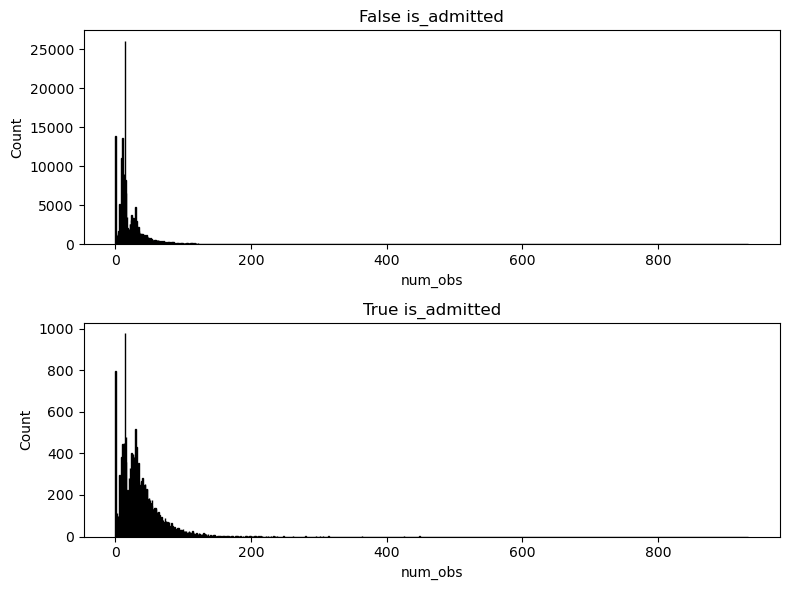

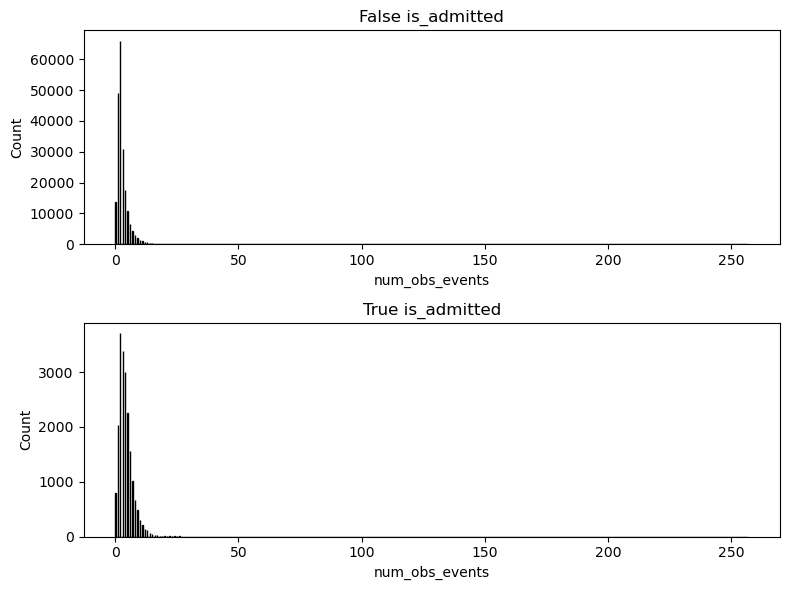

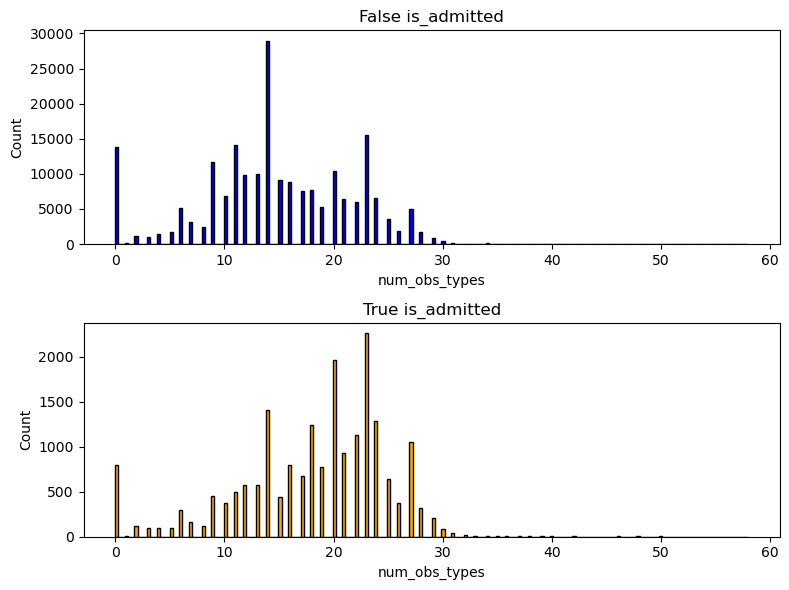

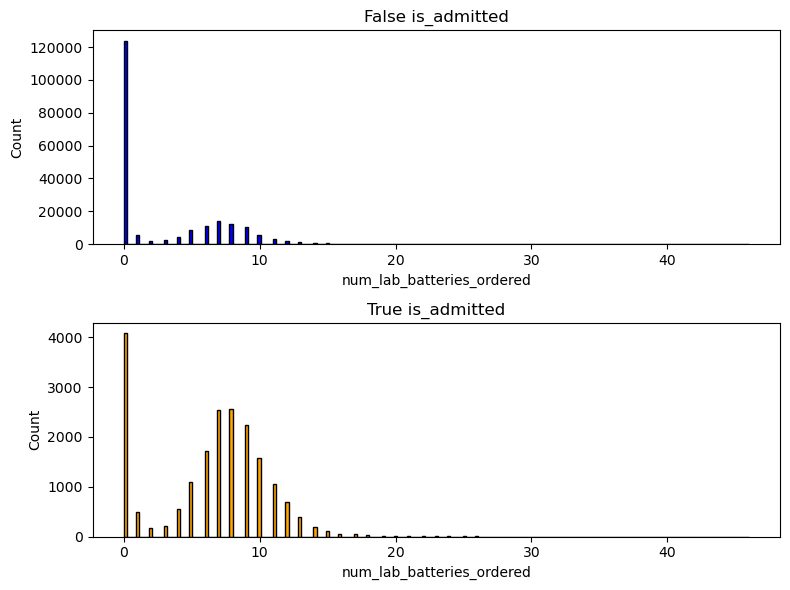

In [23]:
main_plot_function(visits[visits.elapsed_los <= 24*60*60][dict_cols['summary'] + ['is_admitted']], exclude_from_plot)

### Location variables

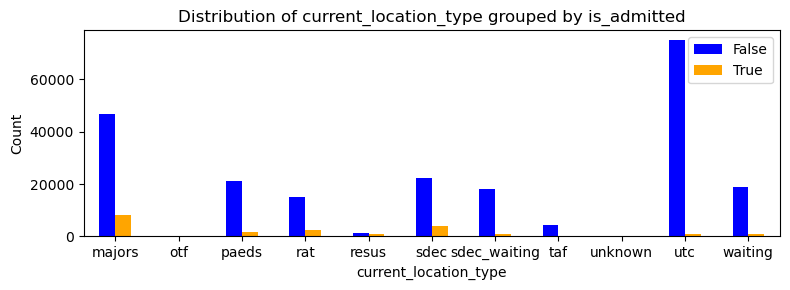

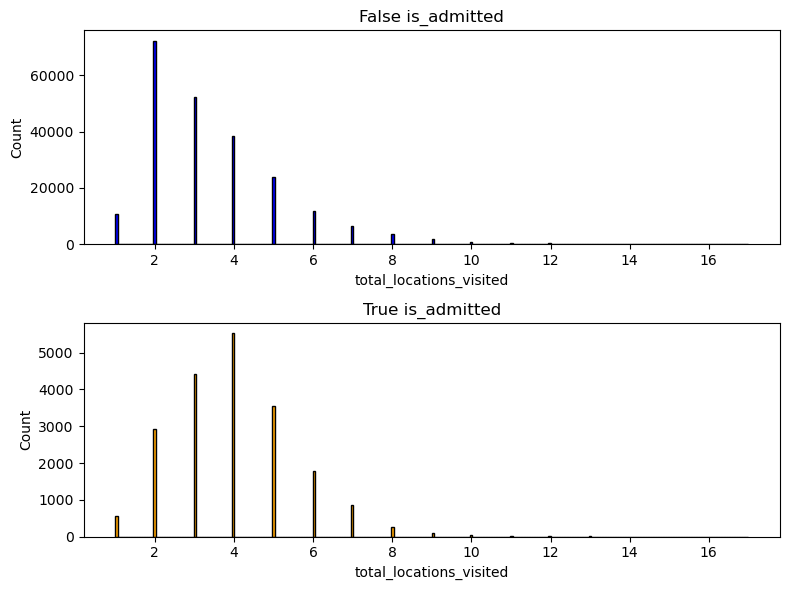

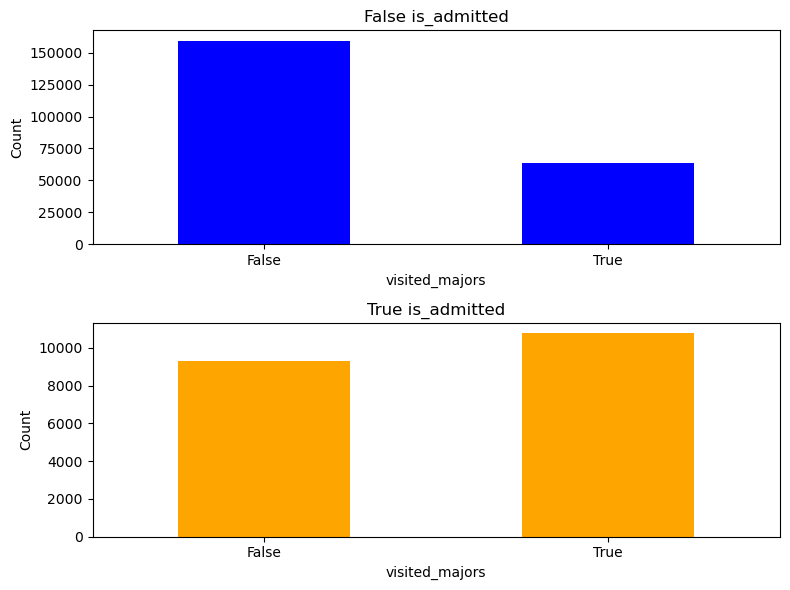

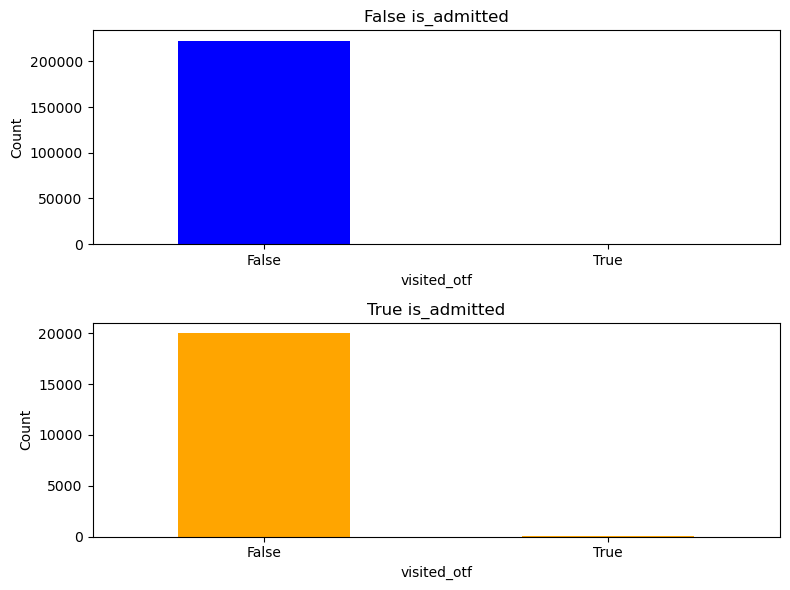

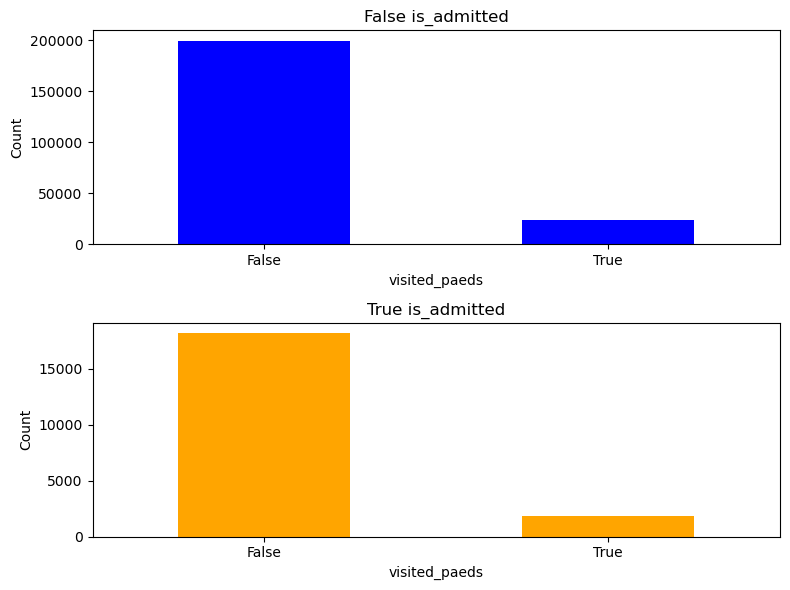

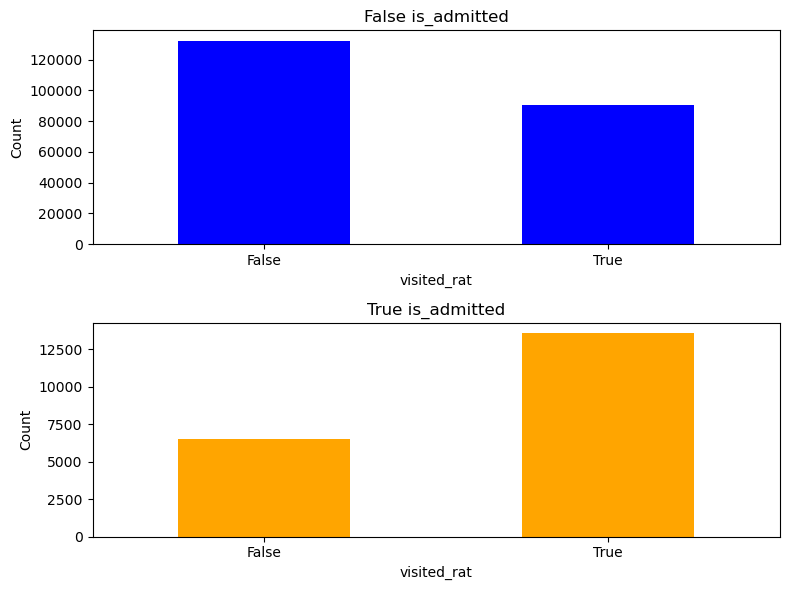

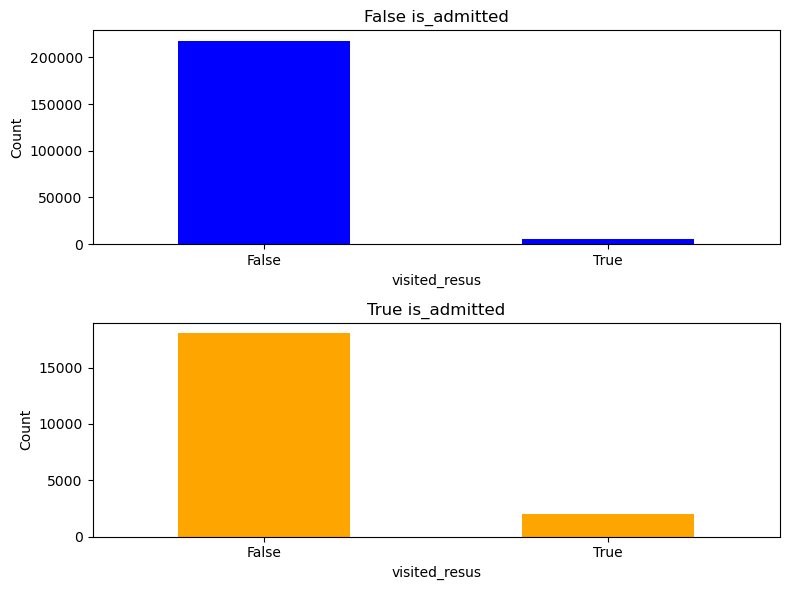

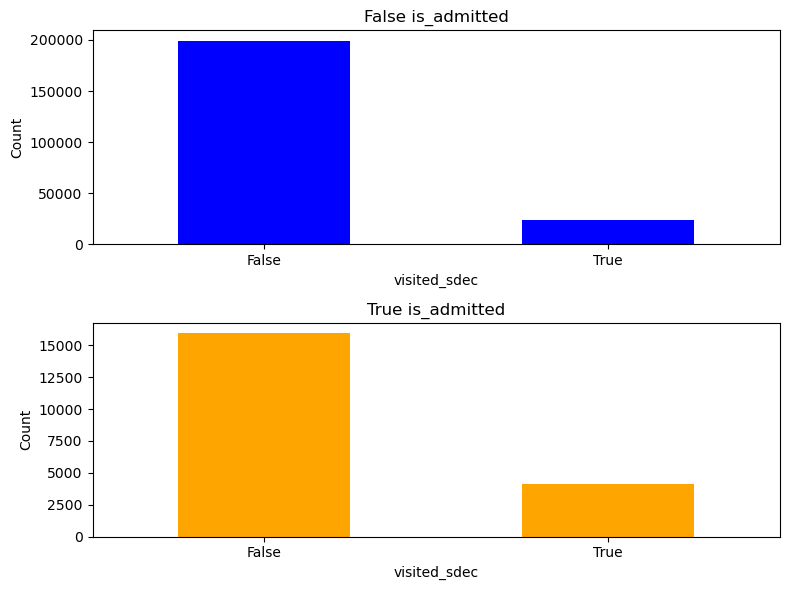

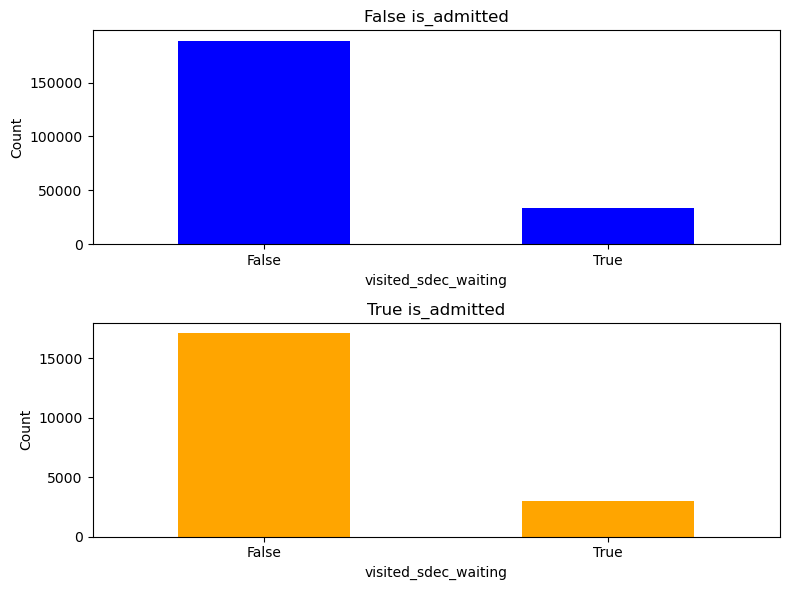

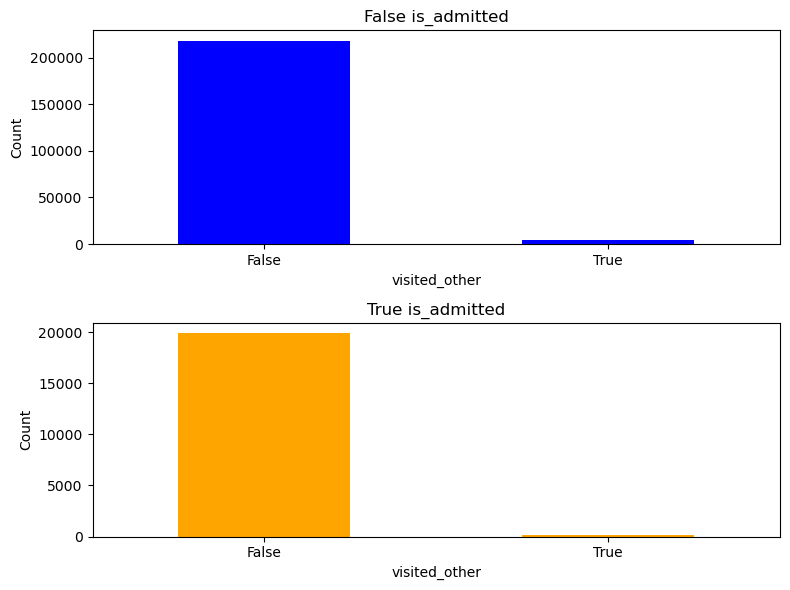

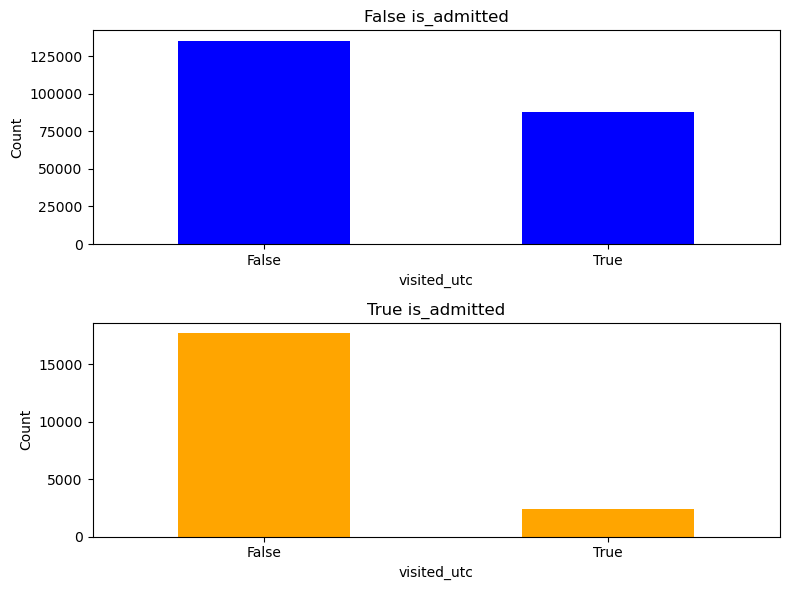

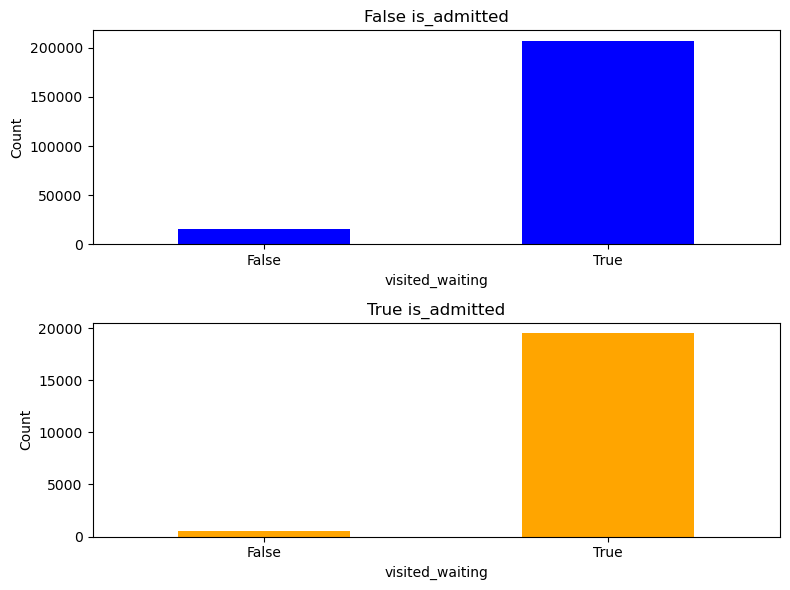

In [24]:
main_plot_function(visits[dict_cols['location'] + ['is_admitted']], exclude_from_plot)

In [83]:
dict_cols.keys()

dict_keys(['not used in training', 'arrival and demographic', 'summary', 'location', 'observations', 'lab orders and results', 'consults', 'outcome'])

### Observations variables

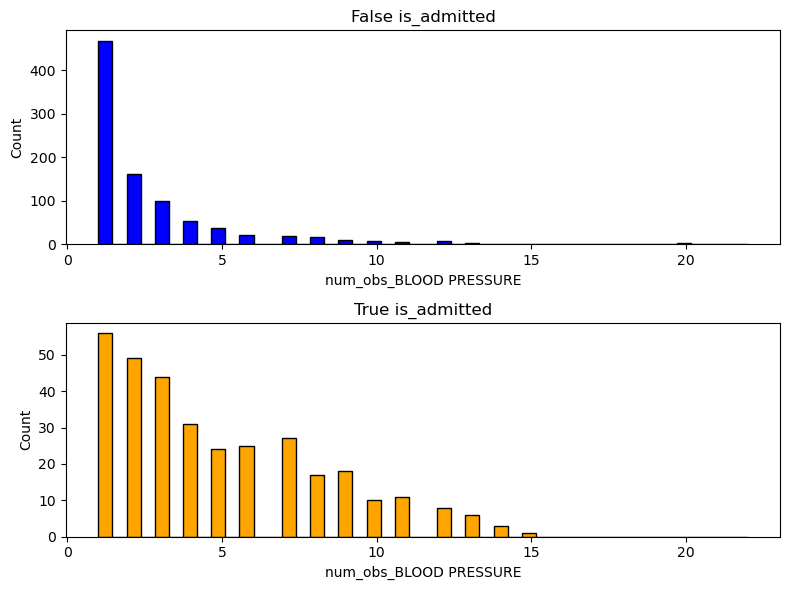

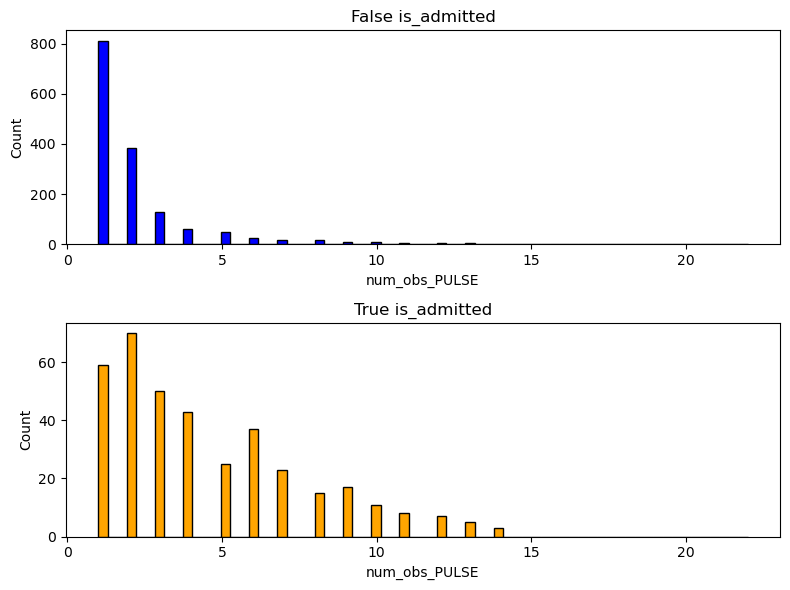

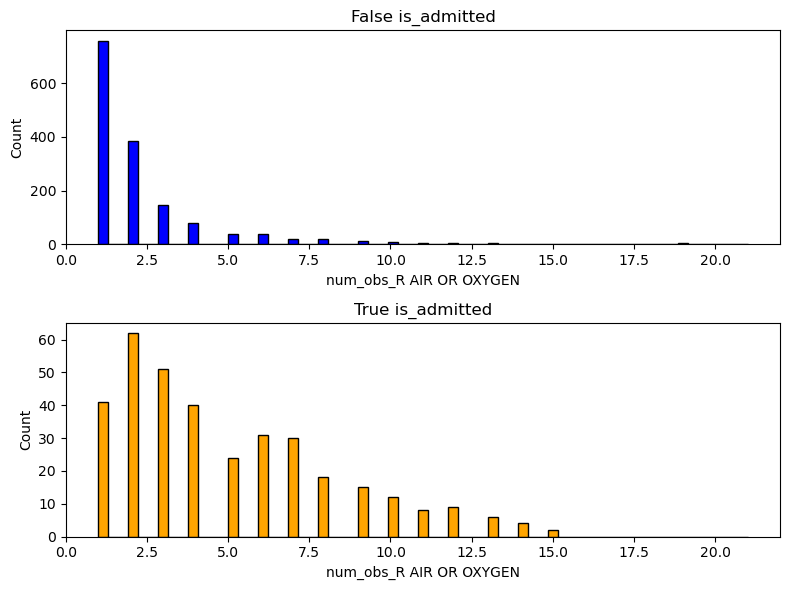

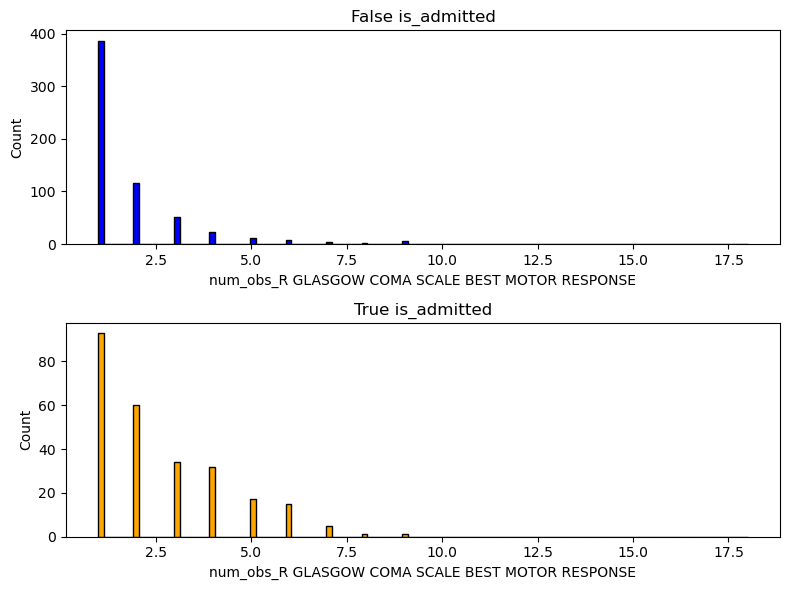

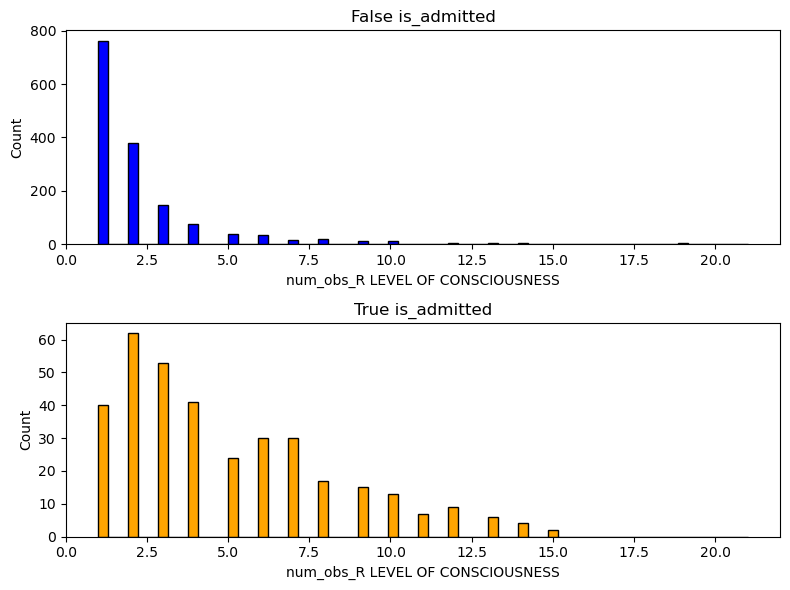

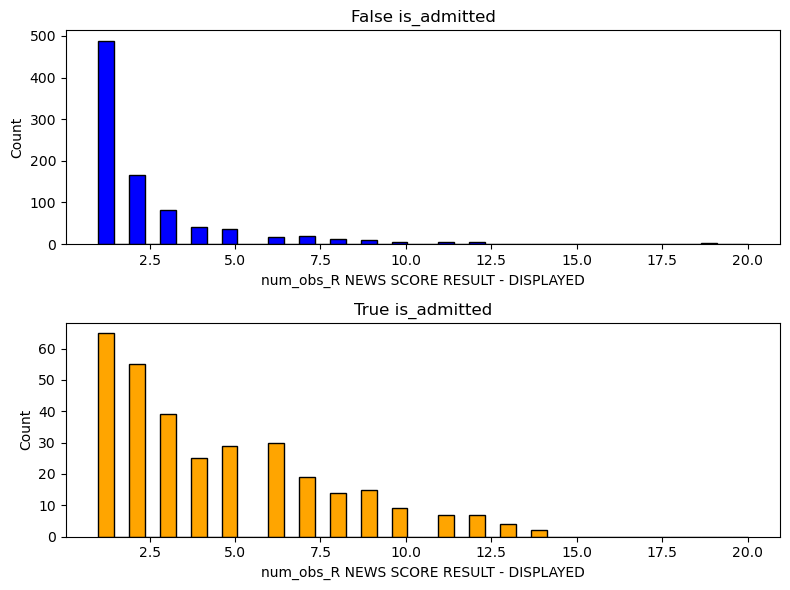

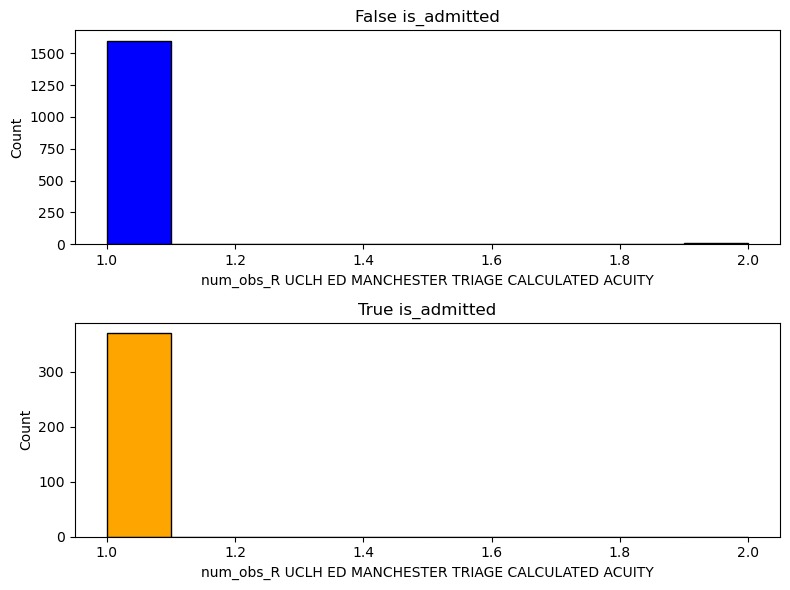

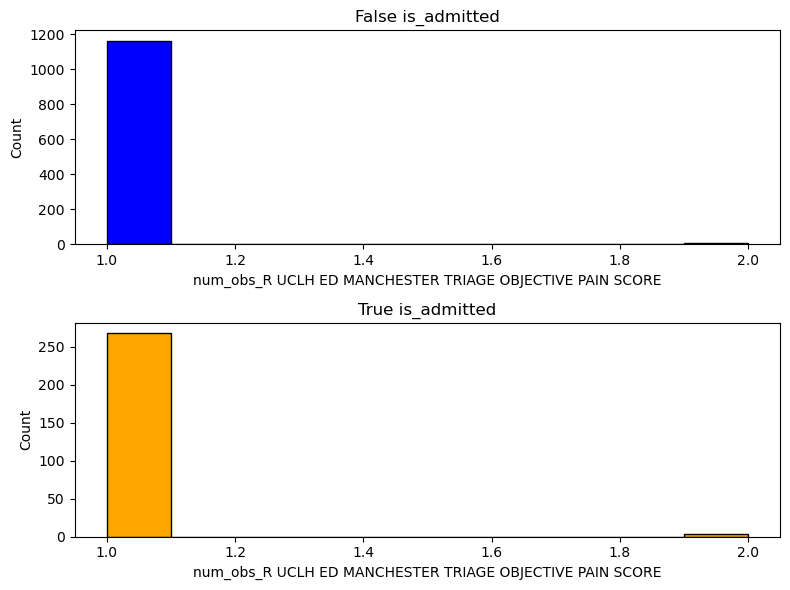

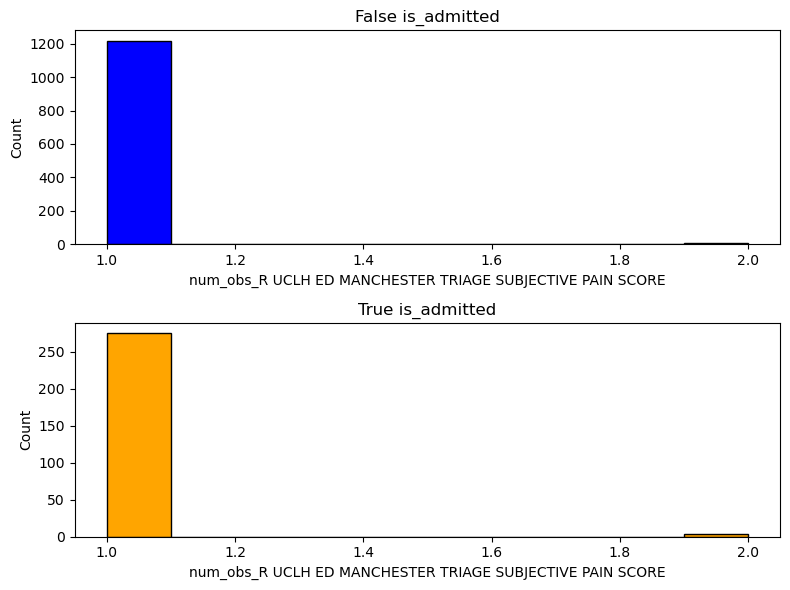

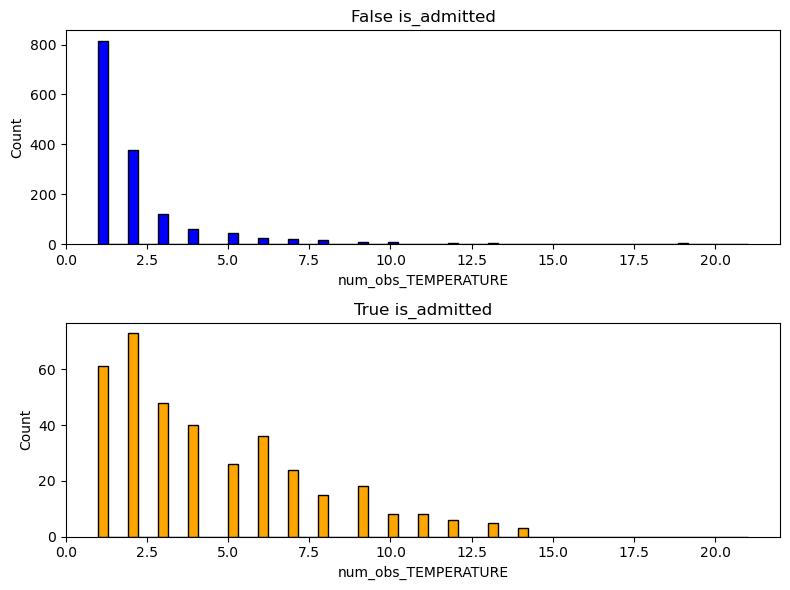

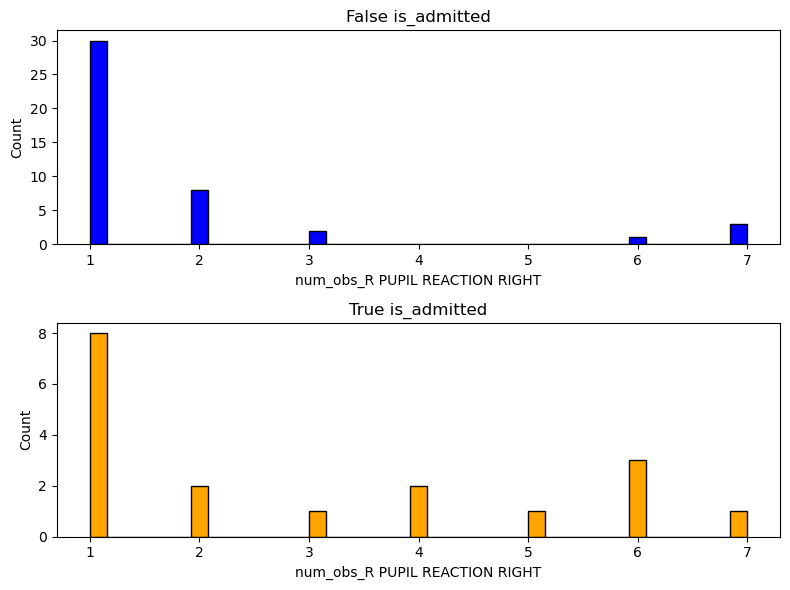

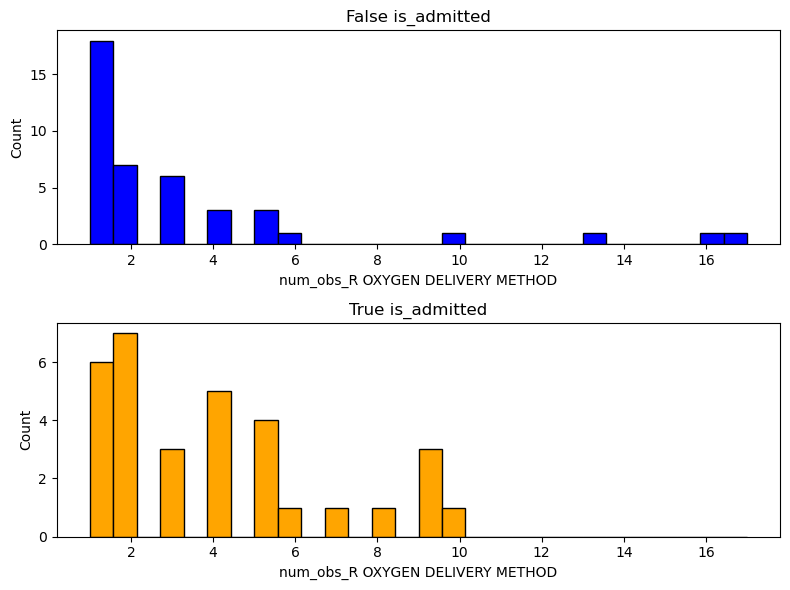

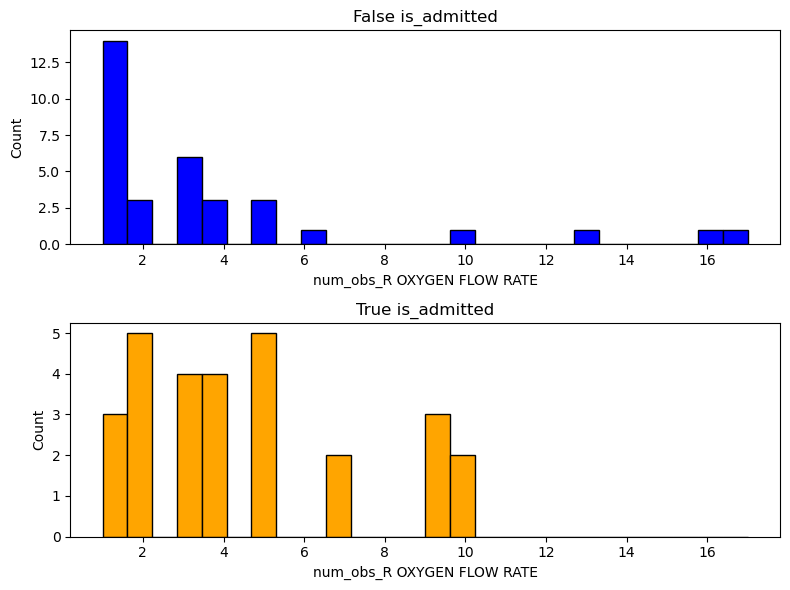

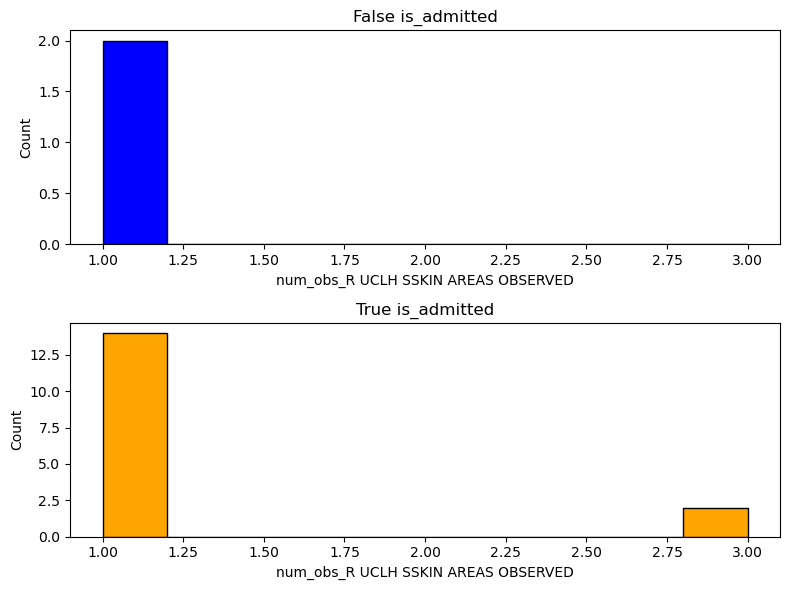

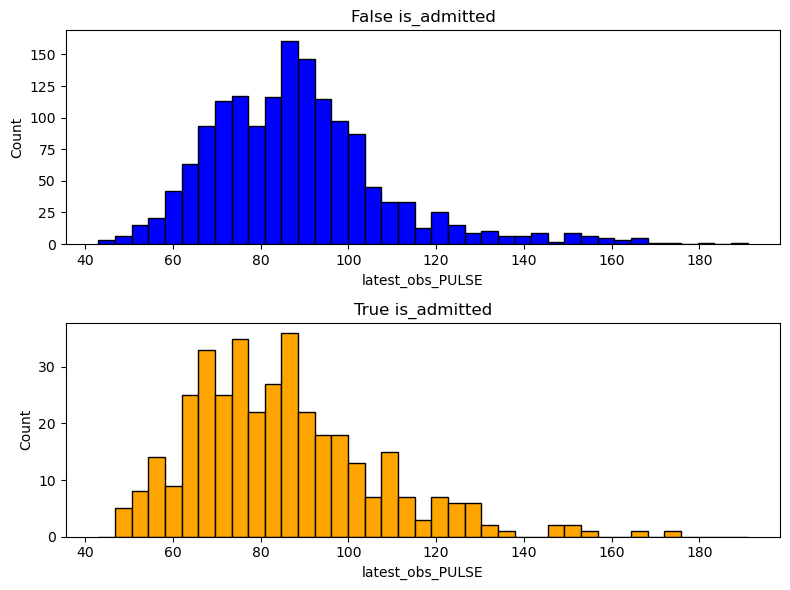

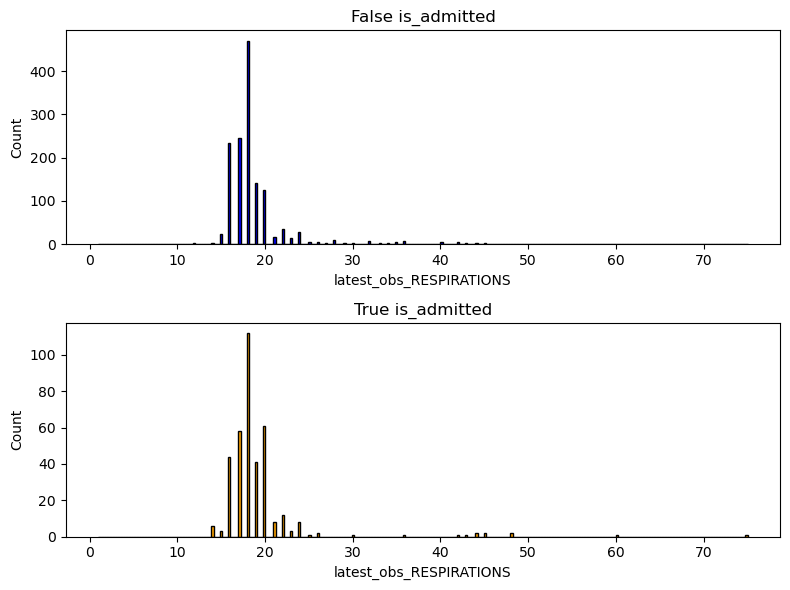

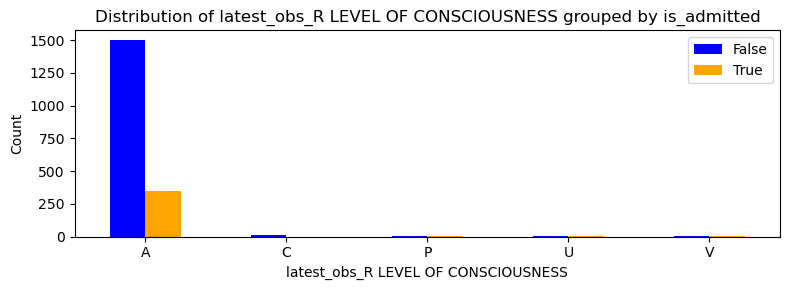

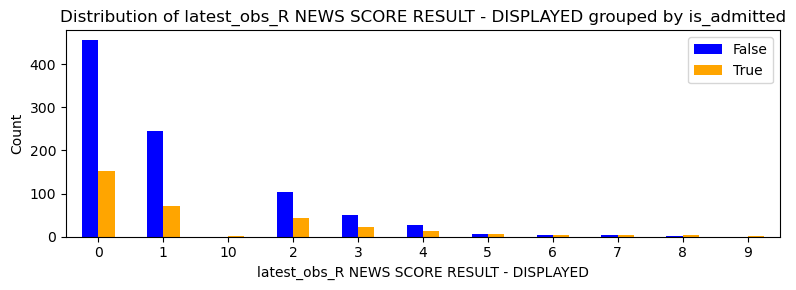

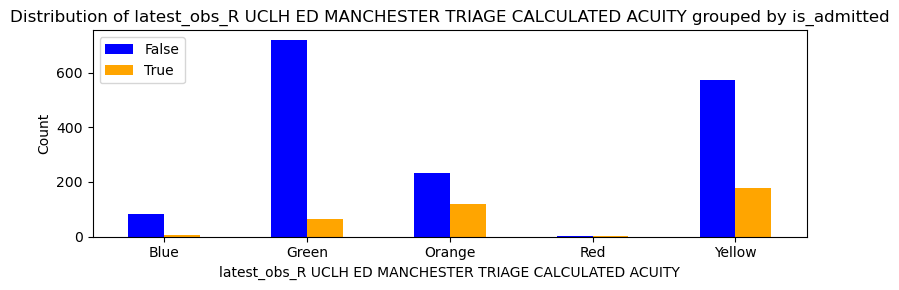

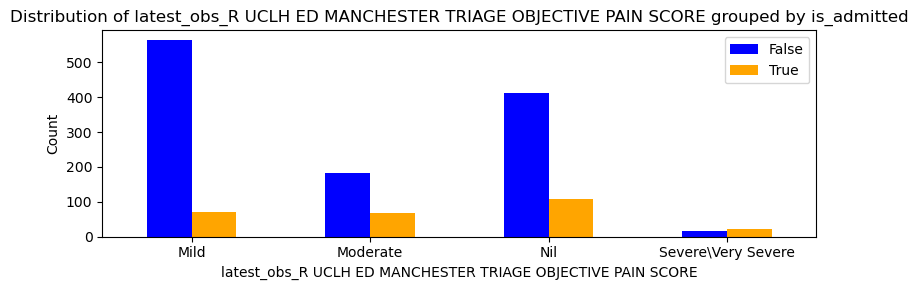

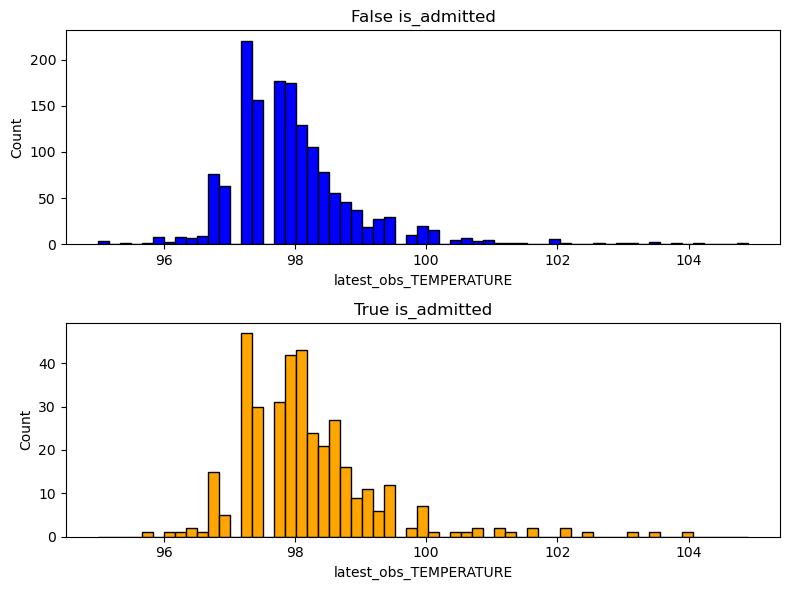

In [84]:
main_plot_function(visits[dict_cols['observations'] + ['is_admitted']], exclude_from_plot)

### Lab variables

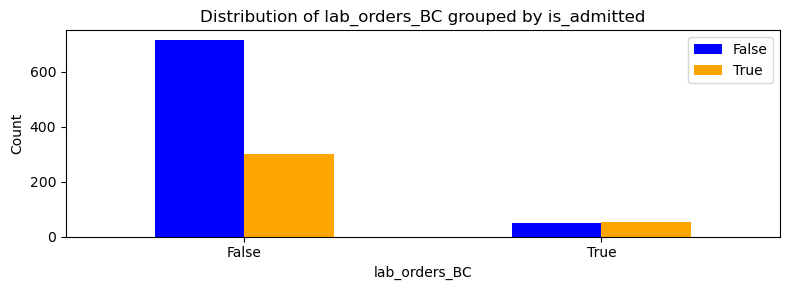

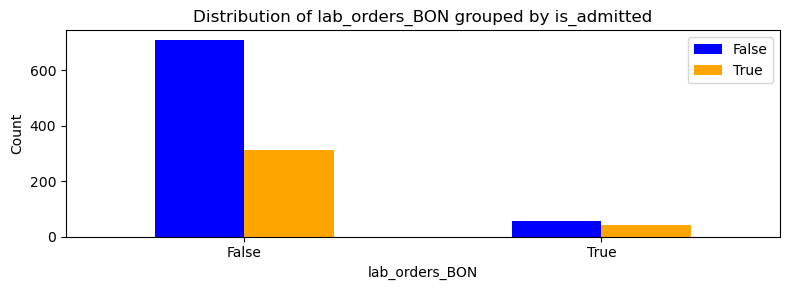

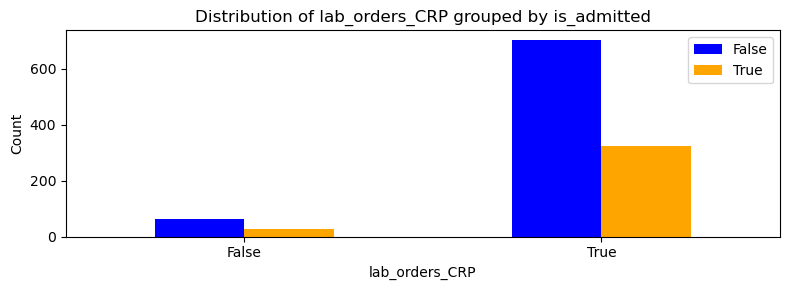

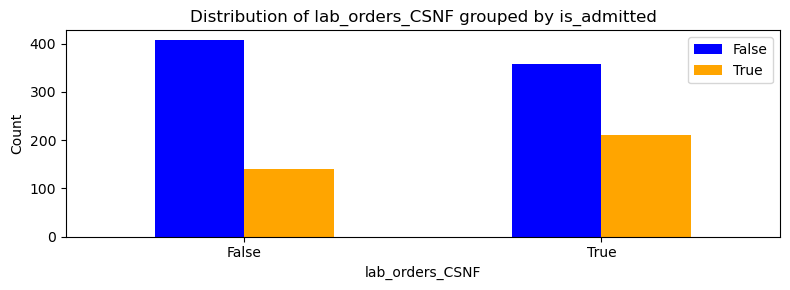

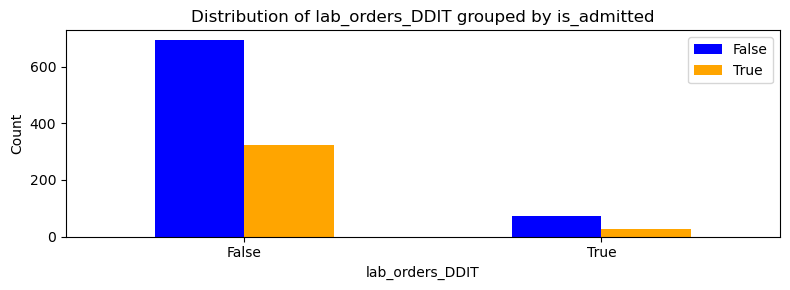

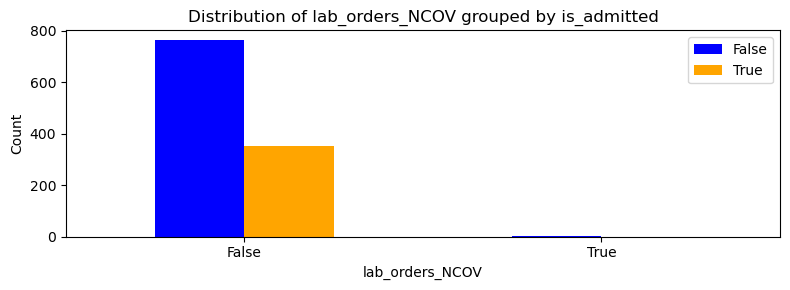

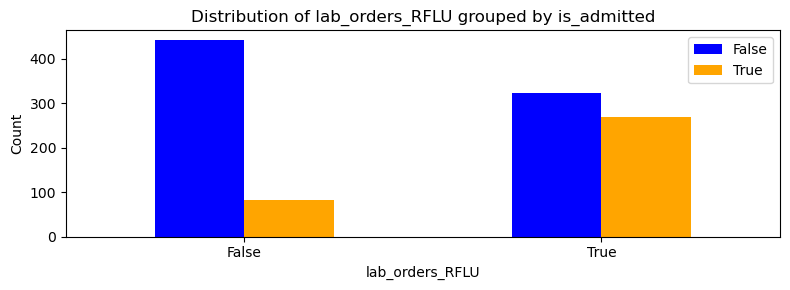

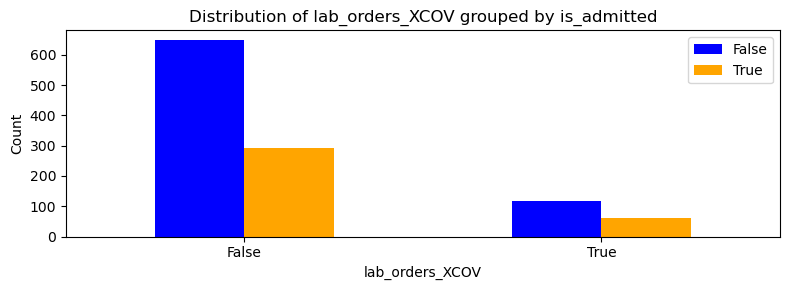

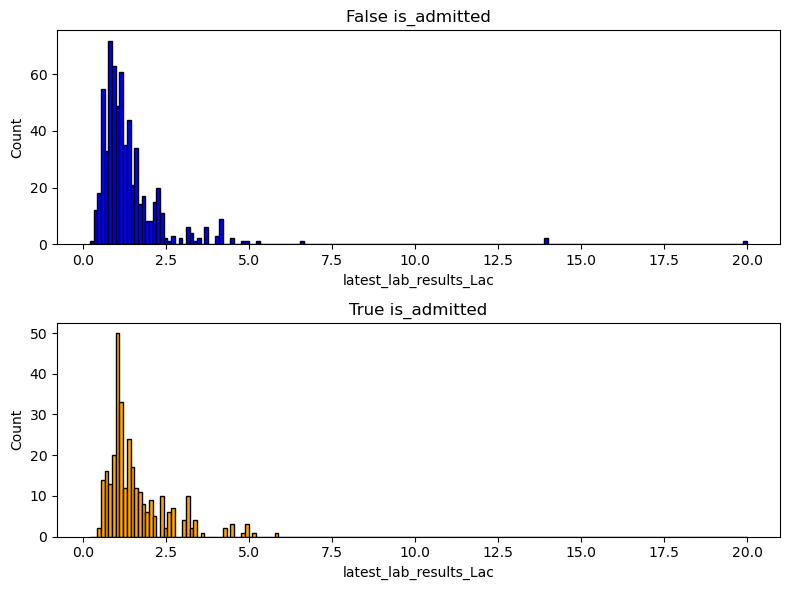

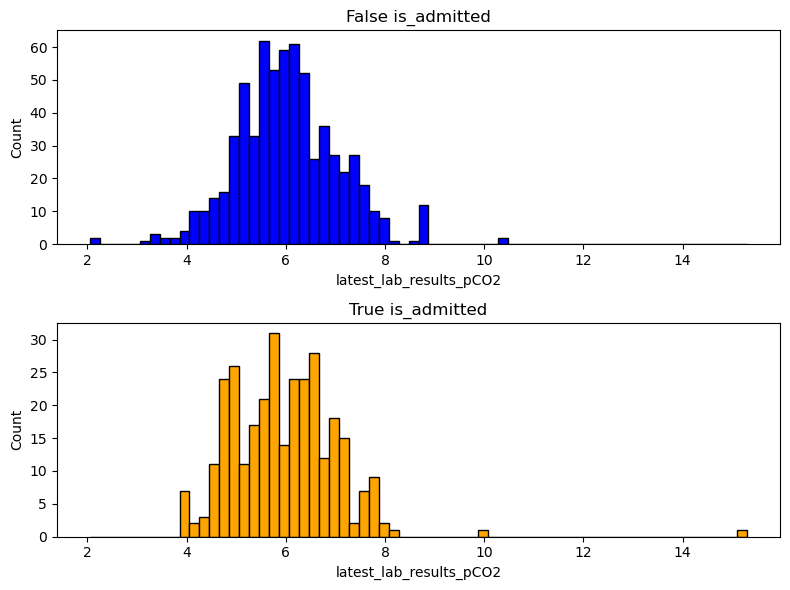

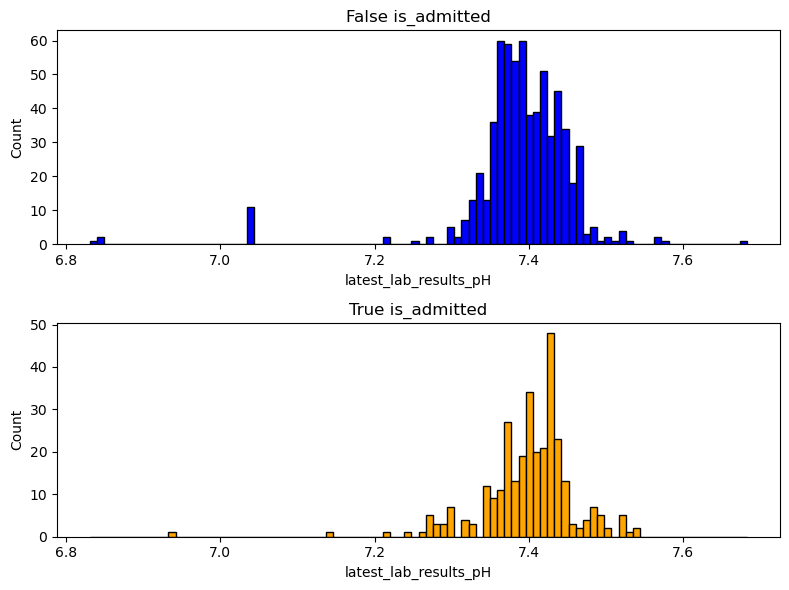

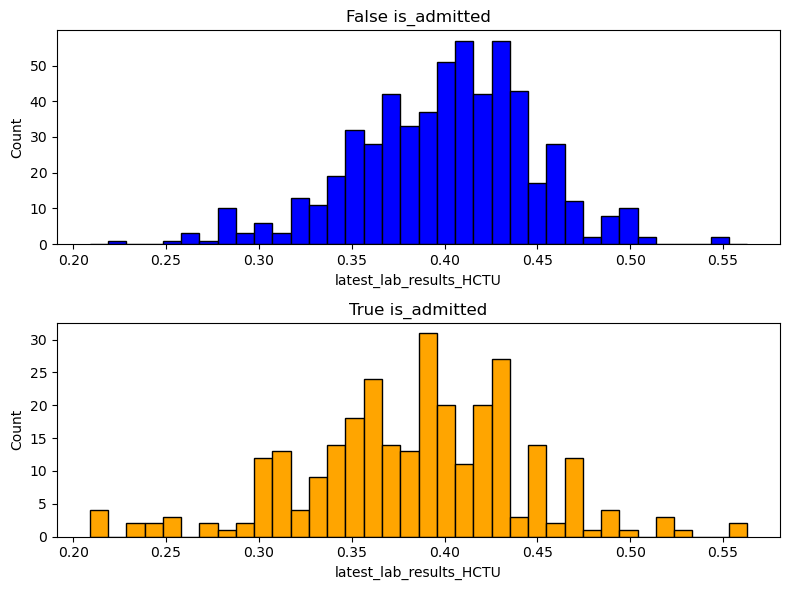

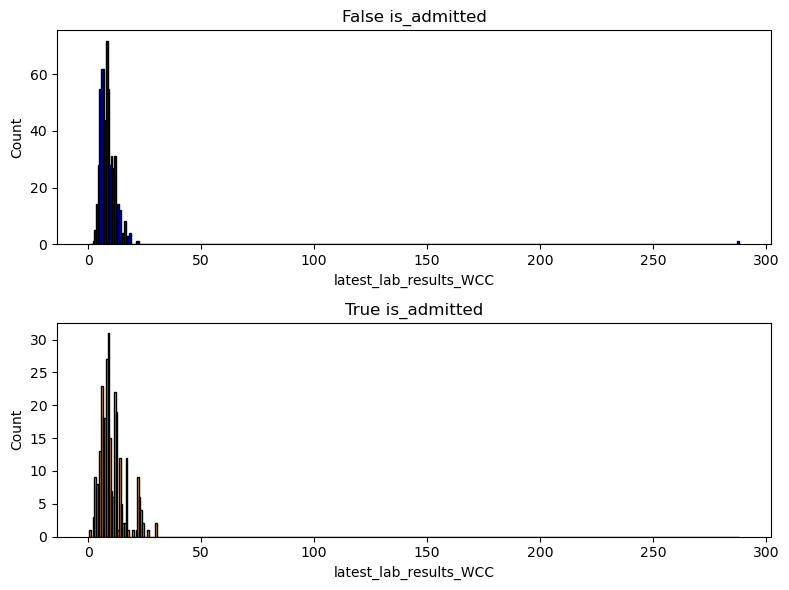

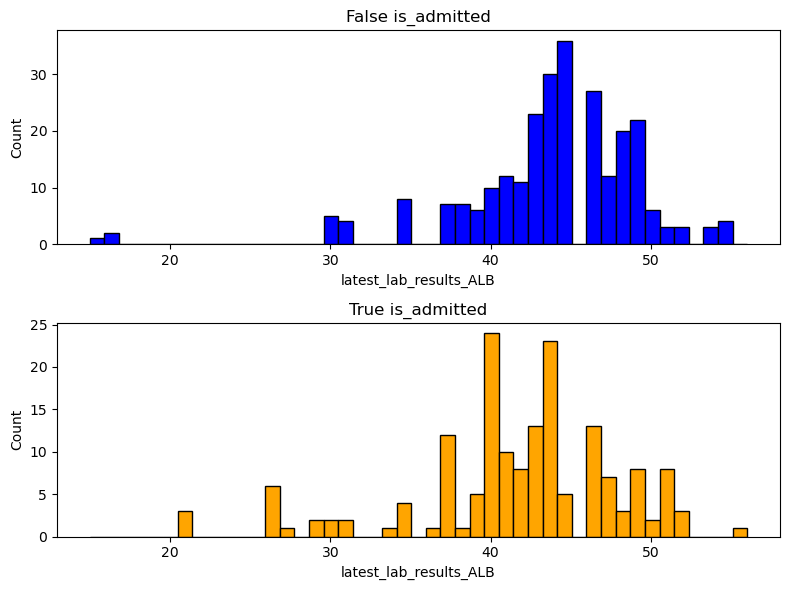

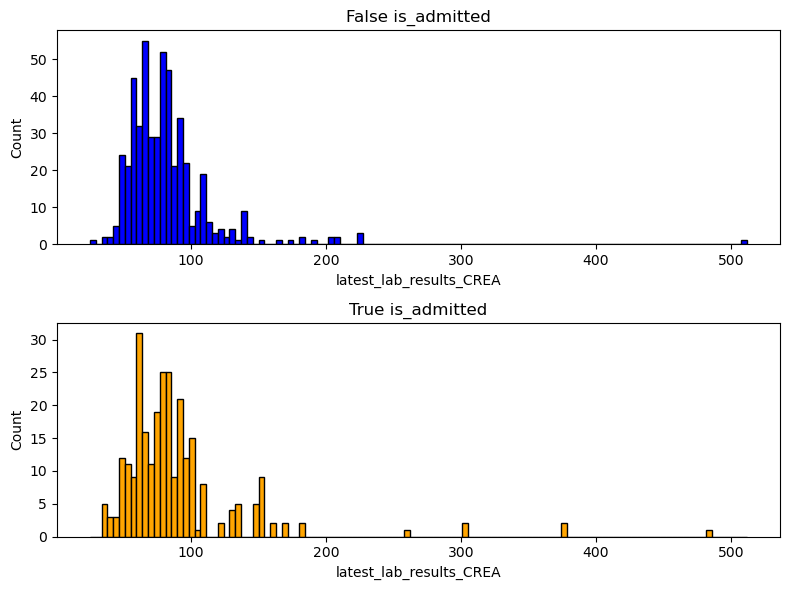

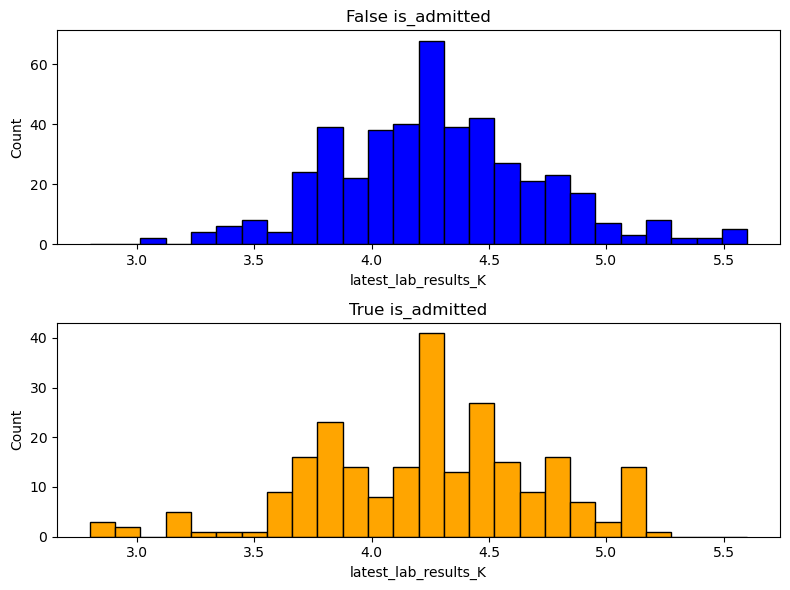

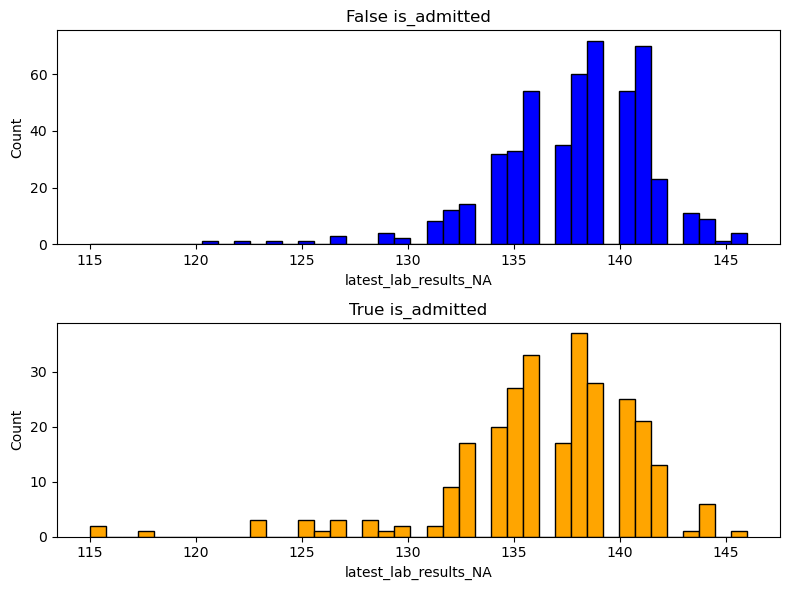

Skipping group True: column latest_lab_results_HCO3 contains only NaN values.


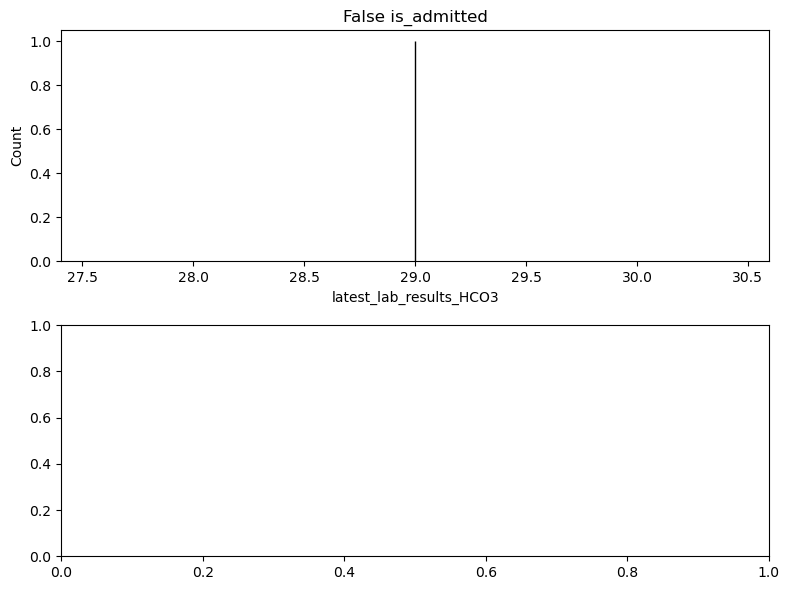

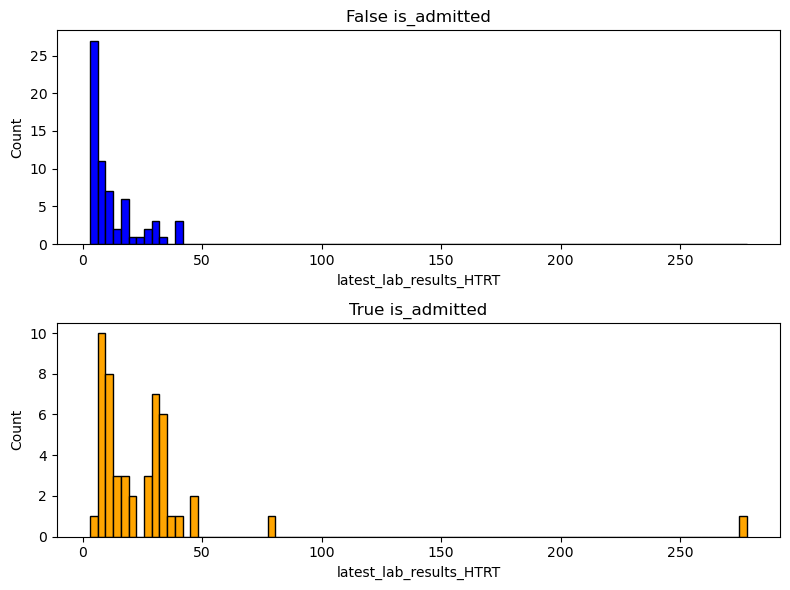

In [70]:
main_plot_function(visits[dict_cols['lab orders and results'] + ['is_admitted']], exclude_from_plot)

### Consults variables

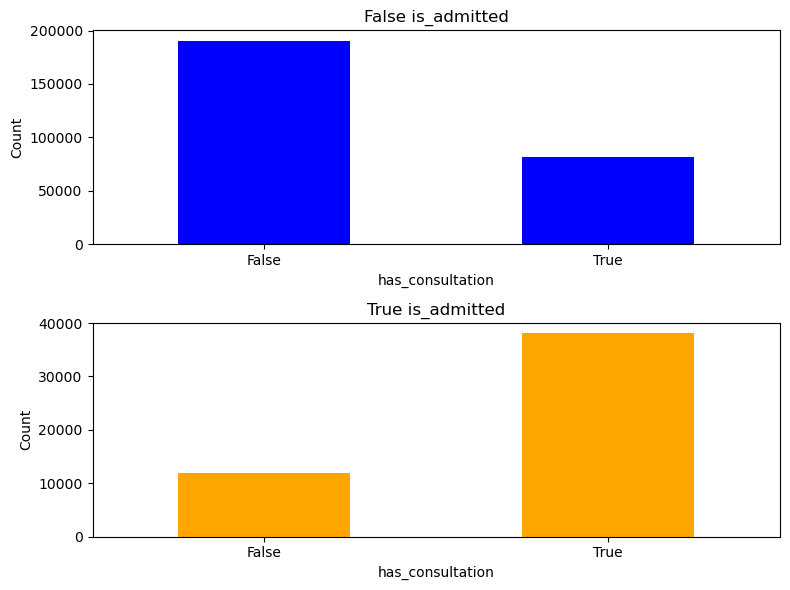

In [93]:
main_plot_function(visits[dict_cols['consults'] + ['is_admitted']], exclude_from_plot)

## Explore Consults dataset

In [95]:


data_filename = 'specialty_' + start_date + '_' + end_date + '.pickle'
full_path = data_path / data_filename

with open(full_path, 'rb') as f:
    spec = pickle.load(f)

In [96]:
spec

,visit_number,consultation_sequence,final_sequence,specialty
snapshot_id,,,,
7,6,[CON47],[CON47],Oncology
8,7,[CON47],[CON47],Oncology
11,9,[CON47],[CON47],Oncology
23,12,[CON57],[CON57],Haematology
25,14,[CON39],[CON39],Urology
...,...,...,...,...
322870,215439,[CON157],[CON157],None
322871,215439,[CON157],[CON157],None
322875,215443,[],[CON10],None


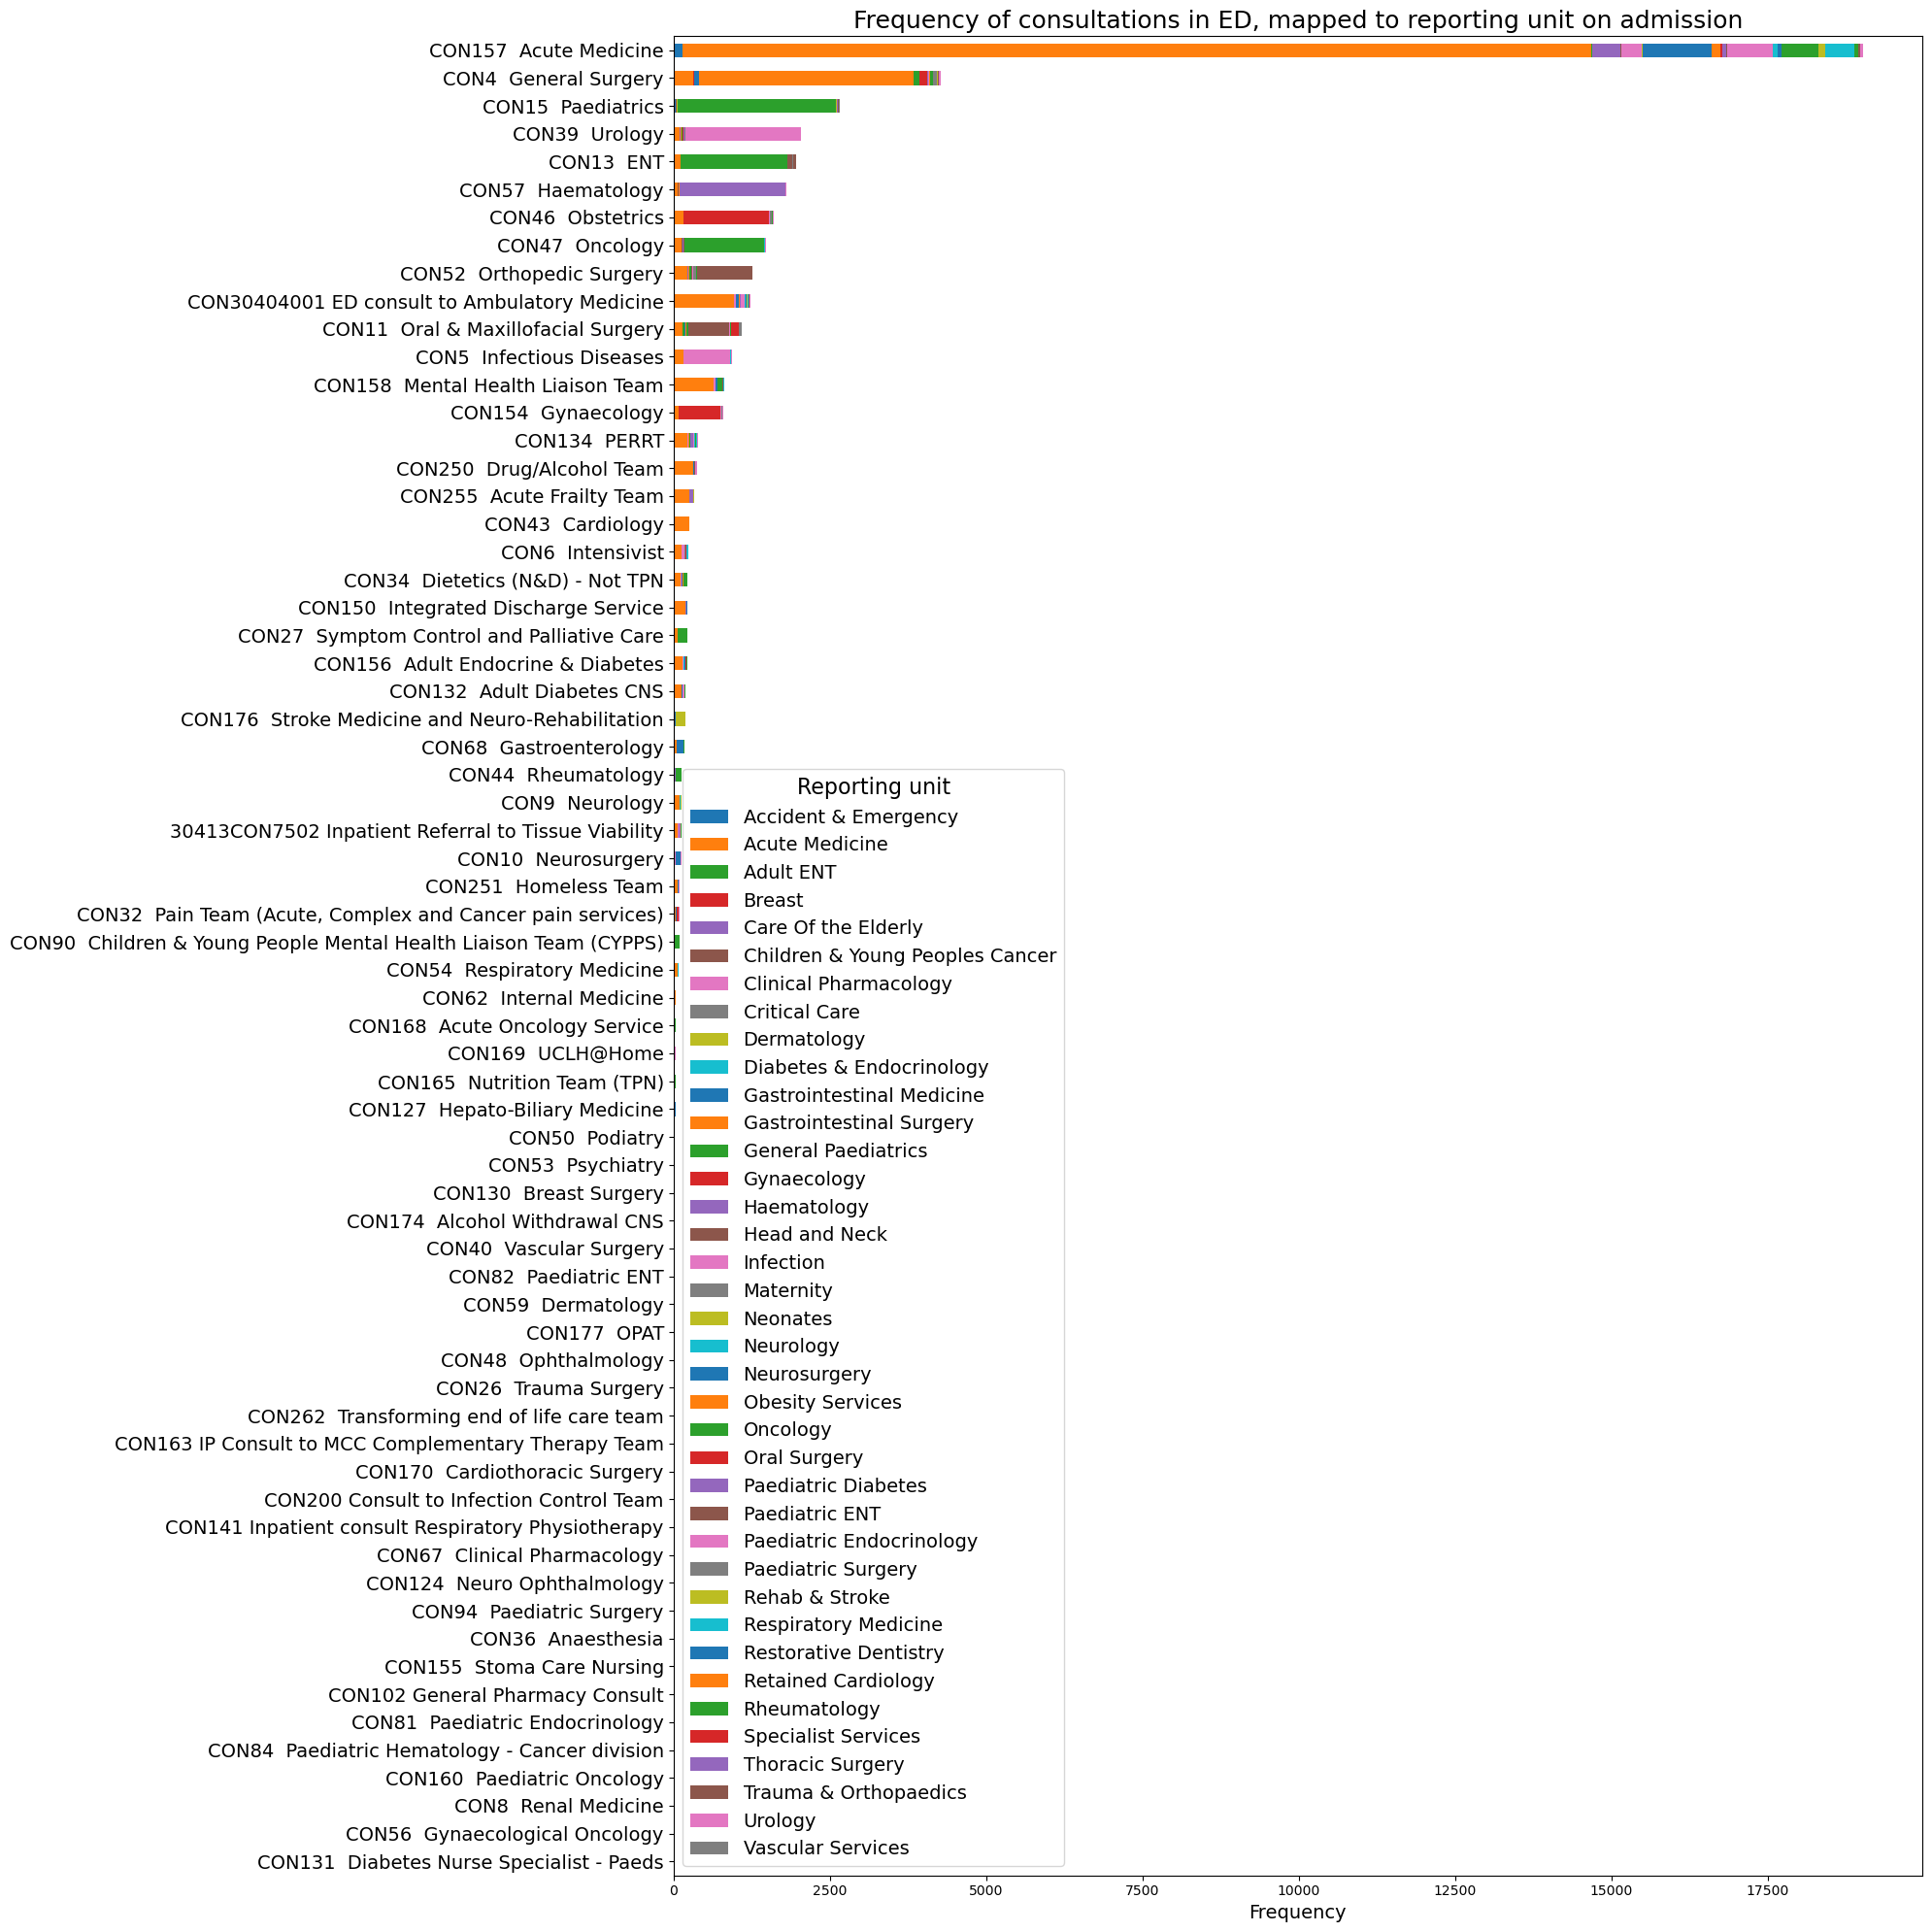

In [98]:
# Plot code if needed

model_input_path = Path(USER_ROOT / 'ed-predictor' / 'model-input')
name_mapping = pd.read_csv(str(model_input_path) + '/consults-mapping.csv')

from matplotlib import pyplot as plt
spec_summ = spec[spec['consultation_sequence'].map(len) > 0][['consultation_sequence', 'specialty']].explode('consultation_sequence').rename(columns = {'consultation_sequence': 'code'})

#.reset_index()
spec_summ = pd.merge(spec_summ, name_mapping, on='code', how='left')
spec_summ['code_name'] = spec_summ['code'] + ' ' +  spec_summ['name'].str.replace('^Inpatient consult to', '',case=False, regex=True)

# Group by both 'code_name' and 'specialty' and count occurrences
frequency = spec_summ.groupby(['code_name', 'specialty']).size().unstack(fill_value=0)

# Sort the DataFrame by the sum of each row (frequency) in descending order
frequency_sorted = frequency.sum(axis=1).sort_values(ascending=True)
frequency = frequency.loc[frequency_sorted.index]

# Create a figure object with desired size
fig, ax = plt.subplots(figsize=(20, 20))
frequency.plot(kind='barh', stacked=True, ax=ax)
plt.xlabel('Frequency', fontsize=14)
plt.ylabel('')
plt.title('Frequency of consultations in ED, mapped to reporting unit on admission', fontsize=18)
ax.legend(title='Reporting unit', fontsize=14, title_fontsize=16)  # Adjust font sizes here

# Adjust the spacing between bars on the y-axis
ax.set_yticks(range(len(frequency.index)))
ax.set_yticklabels(frequency.index, fontsize=14)
plt.tight_layout()  # Ensure tight layout to prevent overlapping
plt.gca().set_aspect('auto')  # Auto-adjust aspect ratio

plt.show()